In [1]:
import torch
import torchtext
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torchtext import data, vocab

import matplotlib.pyplot as plt
%matplotlib inline

import os, sys
import pdb

In [2]:
data_path = '/Users/ivoliv/AI/insera/data/SpeechLabelingService/data'

emb_dim = 50
hidden_dim = 100
num_linear = 3

batch_size = 128

device = 'cpu'

In [3]:
TEXT = data.Field(sequential=True, tokenize='spacy', lower=True)
LABEL = data.Field(sequential=False, use_vocab=False)

In [4]:
datafields = [('tag', None),
              ('statement', TEXT),
              ('tag_id', LABEL)]

trn, vld = data.TabularDataset.splits(
    path=data_path,
    train='train.csv', validation="valid.csv",
    format='csv',
    skip_header=True,
    fields=datafields)

In [5]:
LABEL.build_vocab(trn, vld)

In [6]:
n_classes = len(dict(LABEL.vocab.freqs).keys())
print('Number of classes:', n_classes)

Number of classes: 3


In [7]:
TEXT.build_vocab(trn, vld, vectors='glove.6B.'+str(emb_dim)+'d')

In [8]:
train_iter, val_iter = data.BucketIterator.splits(
    datasets=(trn, vld),
    batch_sizes=(batch_size, batch_size),
    sort_key=lambda x: len(x.statement),
    sort_within_batch=False,
    repeat=False
)

In [9]:
class BatchGenerator:
    def __init__(self, dl, x_field, y_fields):
        self.dl, self.x_field, self.y_fields = dl, x_field, y_fields
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x_field)
            y = getattr(batch, self.y_fields)
            #y = torch.cat([getattr(batch, feat).unsqueeze(1) 
            #               for feat in self.y_fields], dim=1).float()
            yield (X, y)

In [10]:
train_dl = BatchGenerator(train_iter, 'statement', 'tag_id')
valid_dl = BatchGenerator(val_iter, 'statement', 'tag_id')

In [11]:
# Requires padding to be set to 100
class SimpleForward(nn.Module):
    def __init__(self, pretrained_vec, emb_dim=50):
        super().__init__()
        self.embedding = nn.Embedding(len(TEXT.vocab), emb_dim)
        self.embedding.weight.data.copy_(pretrained_vec)
        self.embedding.weight.requires_grad = False
        
        self.linear_layer = nn.Linear(emb_dim*100, 128)
        self.linear_out = nn.Linear(128, n_classes)
        
    def forward(self, seq):
        
        seq = seq.permute(1, 0)
        emb = self.embedding(seq)
        
        long_layer = emb.view(-1, emb_dim*100)
        
        out = F.relu(self.linear_layer(long_layer))
        out = self.linear_out(out)
        
        return F.log_softmax(out, dim=-1)
        

In [12]:
# Requires padding to be set to 100
class CNN(nn.Module):
    def __init__(self, pretrained_vec, emb_dim, n_channels_per_filter, filter_sizes):
        super().__init__()
        self.embedding = nn.Embedding(len(TEXT.vocab), emb_dim)
        self.embedding.weight.data.copy_(pretrained_vec)
        self.embedding.weight.requires_grad = False
        
        self.conv_0 = nn.Conv2d(in_channels=1, out_channels=n_channels_per_filter,
                                kernel_size=(filter_sizes[0], emb_dim))
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=n_channels_per_filter,
                                kernel_size=(filter_sizes[1], emb_dim))
        self.conv_2 = nn.Conv2d(in_channels=1, out_channels=n_channels_per_filter,
                                kernel_size=(filter_sizes[2], emb_dim))
        
        self.fc = nn.Linear(len(filter_sizes)*n_channels_per_filter, n_classes)
        
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, seq):
        
        seq = seq.permute(1, 0)
        emb = self.embedding(seq)
        
        #print(seq.shape)
        #print(emb.shape)
        
        emb = emb.unsqueeze(1) # introduce 'channel 1'
        
        #print('emb:', emb.shape)
        
        out0 = F.relu(self.conv_0(emb).squeeze(3))
        out1 = F.relu(self.conv_1(emb).squeeze(3))
        out2 = F.relu(self.conv_2(emb).squeeze(3))
        
        #print('out0:', out0.shape)
        
        pooled_0 = F.max_pool1d(out0, out0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(out1, out1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(out2, out2.shape[2]).squeeze(2)
        
        #print('pooled0:', pooled_0.shape)
        
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1))
        
        #print('cat:', cat.shape)
        
        out = self.fc(cat)
        
        return F.log_softmax(out, dim=-1)

In [13]:
class simpleRNN(nn.Module):
    def __init__(self, pretrained_vec, emb_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(len(TEXT.vocab), emb_dim)
        self.embedding.weight.data.copy_(pretrained_vec)
        self.embedding.weight.requires_grad = False
        
        self.rnn = nn.RNN(emb_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, n_classes)
        
    def forward(self, seq):
        emb = self.embedding(seq)
        out, hid = self.rnn(emb)
        out = self.fc(hid.squeeze(0))
        
        return F.log_softmax(out, dim=-1)

In [14]:
model = CNN(TEXT.vocab.vectors,
            emb_dim=emb_dim,
            n_channels_per_filter=100,
            filter_sizes=[3, 4, 5]
           ).to(device)

In [15]:
loss_func = nn.NLLLoss()

In [16]:
print(model)

CNN(
  (embedding): Embedding(1081, 50)
  (conv_0): Conv2d(1, 100, kernel_size=(3, 50), stride=(1, 1))
  (conv_1): Conv2d(1, 100, kernel_size=(4, 50), stride=(1, 1))
  (conv_2): Conv2d(1, 100, kernel_size=(5, 50), stride=(1, 1))
  (fc): Linear(in_features=300, out_features=3, bias=True)
  (dropout): Dropout(p=0.5)
)


display(x.shape)
preds = model(x)
display(preds.shape)
preds

In [17]:
import tqdm
 
opt = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()
 
epochs = 200

missclass = []
losses = []
 
for epoch in range(1, epochs + 1):
    running_loss = 0.0
    running_corrects = 0
    model.train() # turn on training mode
    
    num_vals = 0
    num_correct = 0
    
    #pdb.set_trace()
    
    #for x, y in train_dl: 
    for x, y in tqdm.tqdm(train_dl): 
        opt.zero_grad()
 
        preds = model(x)
        loss = loss_func(preds, y.long())

        loss.backward()
        opt.step()
 
        running_loss += loss.item() * x.size(0)
    
        _, y_pred = torch.max(preds, dim=1)
        num_correct += torch.sum(y == y_pred).item()
        num_vals += len(y.float())
        
    #pdb.set_trace()
        
    missclass_tr = 1 - num_correct / num_vals
 
    epoch_loss = running_loss / len(trn)
    
    num_vals = 0
    num_correct = 0

    # calculate the validation loss for this epoch
    val_loss = 0.0
    model.eval() # turn on evaluation mode
    for x, y in tqdm.tqdm(valid_dl):
        preds = model(x)
        loss = loss_func(preds, y.long())
        val_loss += loss.item() * x.size(0)
        
        _, y_pred = torch.max(preds, dim=1)
        num_correct += torch.sum(y == y_pred).item()
        num_vals += len(y.float())
        
    #pdb.set_trace()
        
    missclass_te = 1 - num_correct / num_vals
    val_loss /= len(vld)
    
    missclass.append((missclass_tr, missclass_te))
    losses.append((epoch_loss, val_loss))
    
    print('Epoch: {}, Loss: [{:.4f}, {:.4f}], Miss: [{:.2%}, {:.2%}]'\
          .format(epoch, epoch_loss, val_loss, missclass_tr, missclass_te))
    sys.stdout.flush()

100%|██████████| 1/1 [00:00<00:00, 159.87it/s]

Epoch: 1, Loss: [0.5857, 1.8299], Miss: [52.73%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 154.28it/s]

Epoch: 2, Loss: [0.5975, 1.8391], Miss: [43.90%, 60.00%]



100%|██████████| 1/1 [00:00<00:00, 202.38it/s]

Epoch: 3, Loss: [0.5624, 1.8133], Miss: [39.14%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 201.81it/s]

Epoch: 4, Loss: [0.5013, 1.8084], Miss: [36.93%, 50.00%]



100%|██████████| 1/1 [00:00<00:00, 215.57it/s]

Epoch: 5, Loss: [0.5157, 1.7889], Miss: [33.80%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 219.24it/s]

Epoch: 6, Loss: [0.4909, 1.7631], Miss: [31.59%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 206.99it/s]

Epoch: 7, Loss: [0.4356, 1.7502], Miss: [31.13%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 221.83it/s]

Epoch: 8, Loss: [0.4514, 1.7583], Miss: [29.97%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 76.45it/s]

Epoch: 9, Loss: [0.4555, 1.7440], Miss: [28.22%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 229.77it/s]

Epoch: 10, Loss: [0.4231, 1.7143], Miss: [27.41%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 173.37it/s]

Epoch: 11, Loss: [0.4100, 1.7653], Miss: [26.60%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 233.98it/s]

Epoch: 12, Loss: [0.4380, 1.7132], Miss: [27.18%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 208.21it/s]

Epoch: 13, Loss: [0.4002, 1.7059], Miss: [23.11%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 233.28it/s]

Epoch: 14, Loss: [0.3837, 1.6744], Miss: [24.39%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 172.05it/s]

Epoch: 15, Loss: [0.3457, 1.6673], Miss: [21.72%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 197.71it/s]

Epoch: 16, Loss: [0.3085, 1.6727], Miss: [22.30%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 183.69it/s]

Epoch: 17, Loss: [0.3380, 1.7578], Miss: [19.98%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 202.72it/s]

Epoch: 18, Loss: [0.3200, 1.6614], Miss: [21.14%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 164.34it/s]

Epoch: 19, Loss: [0.3446, 1.6605], Miss: [19.51%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 192.87it/s]

Epoch: 20, Loss: [0.3033, 1.6051], Miss: [19.51%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 208.15it/s]

Epoch: 21, Loss: [0.3312, 1.6863], Miss: [18.35%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 211.29it/s]

Epoch: 22, Loss: [0.2750, 1.6016], Miss: [18.93%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 216.27it/s]

Epoch: 23, Loss: [0.2734, 1.7069], Miss: [16.61%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 167.99it/s]

Epoch: 24, Loss: [0.2917, 1.6311], Miss: [17.31%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 199.41it/s]

Epoch: 25, Loss: [0.2956, 1.7267], Miss: [16.38%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 145.75it/s]

Epoch: 26, Loss: [0.2589, 1.5949], Miss: [16.38%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 181.16it/s]

Epoch: 27, Loss: [0.2916, 1.7457], Miss: [15.33%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 225.03it/s]

Epoch: 28, Loss: [0.2609, 1.6194], Miss: [14.87%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 205.26it/s]

Epoch: 29, Loss: [0.2418, 1.7377], Miss: [13.12%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 213.58it/s]

Epoch: 30, Loss: [0.2510, 1.6390], Miss: [12.78%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 189.11it/s]

Epoch: 31, Loss: [0.2673, 1.7218], Miss: [12.89%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 209.82it/s]

Epoch: 32, Loss: [0.2335, 1.6980], Miss: [13.12%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 197.64it/s]

Epoch: 33, Loss: [0.2236, 1.6999], Miss: [11.27%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 206.57it/s]

Epoch: 34, Loss: [0.2465, 1.6855], Miss: [13.01%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 235.36it/s]

Epoch: 35, Loss: [0.2280, 1.7482], Miss: [12.20%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 179.31it/s]

Epoch: 36, Loss: [0.2421, 1.8758], Miss: [11.85%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 202.55it/s]

Epoch: 37, Loss: [0.2397, 1.7059], Miss: [10.92%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 202.06it/s]

Epoch: 38, Loss: [0.2223, 1.8885], Miss: [12.20%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 177.42it/s]

Epoch: 39, Loss: [0.2299, 1.6521], Miss: [12.89%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 216.55it/s]

Epoch: 40, Loss: [0.2078, 1.8488], Miss: [11.27%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 140.85it/s]

Epoch: 41, Loss: [0.2120, 1.6017], Miss: [12.20%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 206.14it/s]

Epoch: 42, Loss: [0.2045, 1.7684], Miss: [10.69%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 123.89it/s]

Epoch: 43, Loss: [0.2099, 1.8763], Miss: [10.69%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 156.64it/s]

Epoch: 44, Loss: [0.1891, 1.8470], Miss: [10.22%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 133.76it/s]

Epoch: 45, Loss: [0.2202, 1.6352], Miss: [9.87%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 112.73it/s]

Epoch: 46, Loss: [0.2089, 1.8644], Miss: [9.87%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 101.22it/s]

Epoch: 47, Loss: [0.1905, 1.6585], Miss: [10.22%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 108.79it/s]

Epoch: 48, Loss: [0.1962, 1.7626], Miss: [9.87%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 191.56it/s]

Epoch: 49, Loss: [0.1982, 1.6843], Miss: [9.29%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 212.50it/s]

Epoch: 50, Loss: [0.1838, 1.9127], Miss: [9.18%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 188.79it/s]

Epoch: 51, Loss: [0.1970, 1.7527], Miss: [9.29%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 211.81it/s]

Epoch: 52, Loss: [0.1889, 1.8147], Miss: [9.52%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 201.01it/s]

Epoch: 53, Loss: [0.1776, 1.7369], Miss: [9.76%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 191.14it/s]

Epoch: 54, Loss: [0.1820, 1.7958], Miss: [9.18%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 196.00it/s]

Epoch: 55, Loss: [0.1984, 1.6962], Miss: [9.06%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 224.63it/s]

Epoch: 56, Loss: [0.1830, 1.8462], Miss: [10.22%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 196.19it/s]

Epoch: 57, Loss: [0.1827, 1.7887], Miss: [9.06%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 199.36it/s]

Epoch: 58, Loss: [0.1775, 1.9190], Miss: [9.41%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 207.04it/s]

Epoch: 59, Loss: [0.1691, 1.7457], Miss: [9.06%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 250.39it/s]

Epoch: 60, Loss: [0.1928, 1.8487], Miss: [8.94%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 213.90it/s]

Epoch: 61, Loss: [0.1638, 1.8336], Miss: [8.48%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 208.77it/s]

Epoch: 62, Loss: [0.1657, 1.9930], Miss: [8.59%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 191.87it/s]

Epoch: 63, Loss: [0.1668, 1.8572], Miss: [10.10%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 176.45it/s]

Epoch: 64, Loss: [0.1722, 2.0197], Miss: [8.59%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 185.22it/s]

Epoch: 65, Loss: [0.1547, 1.7681], Miss: [9.41%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 128.84it/s]

Epoch: 66, Loss: [0.1644, 1.9078], Miss: [8.25%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 164.96it/s]

Epoch: 67, Loss: [0.1688, 1.7835], Miss: [8.36%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 208.50it/s]

Epoch: 68, Loss: [0.1625, 1.8912], Miss: [8.25%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 192.02it/s]

Epoch: 69, Loss: [0.1596, 1.8286], Miss: [8.25%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 188.29it/s]

Epoch: 70, Loss: [0.1534, 1.7218], Miss: [8.71%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 231.33it/s]

Epoch: 71, Loss: [0.1551, 1.8940], Miss: [8.71%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 208.65it/s]

Epoch: 72, Loss: [0.1550, 1.9251], Miss: [7.78%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 203.87it/s]

Epoch: 73, Loss: [0.1583, 1.9477], Miss: [8.36%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 123.21it/s]

Epoch: 74, Loss: [0.1578, 1.9200], Miss: [8.59%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 111.95it/s]

Epoch: 75, Loss: [0.1732, 1.7677], Miss: [8.71%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 196.38it/s]

Epoch: 76, Loss: [0.1493, 1.9168], Miss: [8.25%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 209.15it/s]

Epoch: 77, Loss: [0.1492, 1.7777], Miss: [8.36%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 206.95it/s]

Epoch: 78, Loss: [0.1469, 1.8882], Miss: [9.06%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 183.89it/s]

Epoch: 79, Loss: [0.1363, 1.9021], Miss: [8.48%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 221.52it/s]

Epoch: 80, Loss: [0.1504, 2.0105], Miss: [8.59%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 169.75it/s]

Epoch: 81, Loss: [0.1631, 2.0347], Miss: [8.48%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 193.69it/s]

Epoch: 82, Loss: [0.1562, 1.8321], Miss: [8.25%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 199.89it/s]

Epoch: 83, Loss: [0.1480, 1.9777], Miss: [7.43%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 180.02it/s]

Epoch: 84, Loss: [0.1556, 1.8558], Miss: [8.36%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 219.15it/s]

Epoch: 85, Loss: [0.1588, 2.0908], Miss: [8.59%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 218.06it/s]

Epoch: 86, Loss: [0.1549, 1.9543], Miss: [7.90%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 182.24it/s]

Epoch: 87, Loss: [0.1546, 1.9592], Miss: [8.25%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 199.52it/s]

Epoch: 88, Loss: [0.1372, 1.8852], Miss: [7.90%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 156.61it/s]

Epoch: 89, Loss: [0.1403, 1.9553], Miss: [7.43%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 157.28it/s]

Epoch: 90, Loss: [0.1540, 1.8097], Miss: [8.36%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 197.83it/s]

Epoch: 91, Loss: [0.1525, 1.9677], Miss: [8.13%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 186.60it/s]

Epoch: 92, Loss: [0.1493, 1.8190], Miss: [7.67%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 212.54it/s]

Epoch: 93, Loss: [0.1394, 1.8683], Miss: [7.78%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 180.93it/s]

Epoch: 94, Loss: [0.1426, 2.0360], Miss: [8.36%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 198.74it/s]

Epoch: 95, Loss: [0.1431, 1.8972], Miss: [8.01%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 210.71it/s]

Epoch: 96, Loss: [0.1311, 1.7503], Miss: [8.13%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 171.91it/s]

Epoch: 97, Loss: [0.1392, 1.8165], Miss: [7.78%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 191.32it/s]

Epoch: 98, Loss: [0.1484, 1.8914], Miss: [8.36%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 162.55it/s]

Epoch: 99, Loss: [0.1482, 1.9167], Miss: [7.90%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 176.87it/s]

Epoch: 100, Loss: [0.1477, 2.1827], Miss: [8.01%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 125.21it/s]

Epoch: 101, Loss: [0.1424, 1.7925], Miss: [8.48%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 209.43it/s]

Epoch: 102, Loss: [0.1421, 1.9671], Miss: [7.90%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 230.00it/s]

Epoch: 103, Loss: [0.1373, 1.6707], Miss: [7.67%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 161.15it/s]

Epoch: 104, Loss: [0.1450, 1.9477], Miss: [7.90%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

Epoch: 105, Loss: [0.1359, 1.7530], Miss: [8.13%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 163.45it/s]

Epoch: 106, Loss: [0.1345, 1.7868], Miss: [7.43%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 161.29it/s]

Epoch: 107, Loss: [0.1322, 2.0734], Miss: [7.90%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 141.57it/s]

Epoch: 108, Loss: [0.1363, 1.7208], Miss: [7.67%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 135.40it/s]

Epoch: 109, Loss: [0.1268, 1.9500], Miss: [7.67%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 179.57it/s]

Epoch: 110, Loss: [0.1492, 1.7600], Miss: [7.78%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 118.96it/s]

Epoch: 111, Loss: [0.1434, 1.9362], Miss: [7.67%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 98.23it/s]

Epoch: 112, Loss: [0.1326, 2.1010], Miss: [8.01%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 193.61it/s]

Epoch: 113, Loss: [0.1286, 1.9580], Miss: [7.78%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 156.13it/s]

Epoch: 114, Loss: [0.1413, 2.2680], Miss: [7.78%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 215.76it/s]

Epoch: 115, Loss: [0.1423, 1.9968], Miss: [7.08%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 214.67it/s]

Epoch: 116, Loss: [0.1372, 1.6069], Miss: [7.32%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 182.49it/s]

Epoch: 117, Loss: [0.1339, 1.9904], Miss: [7.43%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 197.82it/s]

Epoch: 118, Loss: [0.1307, 2.0202], Miss: [7.32%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 205.76it/s]

Epoch: 119, Loss: [0.1331, 1.8499], Miss: [8.01%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 153.37it/s]

Epoch: 120, Loss: [0.1322, 1.8923], Miss: [7.43%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 163.77it/s]

Epoch: 121, Loss: [0.1235, 1.7803], Miss: [7.78%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 91.56it/s]

Epoch: 122, Loss: [0.1445, 2.0720], Miss: [7.90%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 116.22it/s]

Epoch: 123, Loss: [0.1496, 2.0112], Miss: [7.43%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 96.69it/s]

Epoch: 124, Loss: [0.1294, 1.7511], Miss: [7.55%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 191.87it/s]

Epoch: 125, Loss: [0.1408, 1.8909], Miss: [7.67%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 182.16it/s]

Epoch: 126, Loss: [0.1343, 1.8423], Miss: [7.78%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 171.46it/s]

Epoch: 127, Loss: [0.1385, 1.9646], Miss: [7.55%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 215.52it/s]

Epoch: 128, Loss: [0.1478, 2.0630], Miss: [8.01%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 166.67it/s]

Epoch: 129, Loss: [0.1300, 1.9336], Miss: [7.67%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 194.97it/s]

Epoch: 130, Loss: [0.1317, 2.1697], Miss: [7.20%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 189.46it/s]

Epoch: 131, Loss: [0.1313, 1.7846], Miss: [7.55%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 177.43it/s]

Epoch: 132, Loss: [0.1324, 1.8253], Miss: [7.43%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 192.31it/s]

Epoch: 133, Loss: [0.1391, 1.9115], Miss: [7.55%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 201.82it/s]

Epoch: 134, Loss: [0.1265, 2.0083], Miss: [7.20%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 178.25it/s]

Epoch: 135, Loss: [0.1280, 2.2286], Miss: [7.20%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 170.39it/s]

Epoch: 136, Loss: [0.1284, 1.7004], Miss: [7.67%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 162.15it/s]

Epoch: 137, Loss: [0.1520, 2.2129], Miss: [7.67%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 209.45it/s]

Epoch: 138, Loss: [0.1200, 1.9532], Miss: [7.67%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 183.16it/s]

Epoch: 139, Loss: [0.1396, 1.9176], Miss: [7.55%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 226.71it/s]

Epoch: 140, Loss: [0.1500, 2.0844], Miss: [7.43%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 201.45it/s]

Epoch: 141, Loss: [0.1224, 1.7898], Miss: [7.43%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 187.90it/s]

Epoch: 142, Loss: [0.1323, 2.0817], Miss: [7.32%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 167.11it/s]

Epoch: 143, Loss: [0.1385, 2.1761], Miss: [7.20%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 172.18it/s]

Epoch: 144, Loss: [0.1302, 1.7551], Miss: [7.20%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 185.66it/s]

Epoch: 145, Loss: [0.1249, 2.3502], Miss: [7.32%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 158.51it/s]

Epoch: 146, Loss: [0.1330, 1.9855], Miss: [7.43%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 211.43it/s]

Epoch: 147, Loss: [0.1330, 1.8997], Miss: [7.55%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 84.29it/s]

Epoch: 148, Loss: [0.1325, 2.0618], Miss: [7.32%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 185.11it/s]

Epoch: 149, Loss: [0.1169, 2.0402], Miss: [7.08%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 211.92it/s]

Epoch: 150, Loss: [0.1222, 2.1611], Miss: [7.55%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 223.77it/s]

Epoch: 151, Loss: [0.1370, 1.8621], Miss: [7.90%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 195.27it/s]

Epoch: 152, Loss: [0.1331, 1.8413], Miss: [7.32%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 174.43it/s]

Epoch: 153, Loss: [0.1339, 1.9520], Miss: [7.55%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 137.85it/s]

Epoch: 154, Loss: [0.1181, 1.9858], Miss: [6.85%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 193.95it/s]

Epoch: 155, Loss: [0.1371, 2.0728], Miss: [7.20%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 205.17it/s]

Epoch: 156, Loss: [0.1276, 2.1689], Miss: [6.97%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 192.53it/s]

Epoch: 157, Loss: [0.1297, 2.3397], Miss: [7.43%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 53.66it/s]

Epoch: 158, Loss: [0.1233, 2.0766], Miss: [7.43%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 174.37it/s]

Epoch: 159, Loss: [0.1127, 2.1163], Miss: [7.43%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 167.79it/s]

Epoch: 160, Loss: [0.1394, 2.2037], Miss: [7.32%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 211.64it/s]

Epoch: 161, Loss: [0.1239, 2.1543], Miss: [7.32%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 162.94it/s]

Epoch: 162, Loss: [0.1340, 2.2985], Miss: [7.20%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 219.59it/s]

Epoch: 163, Loss: [0.1327, 1.9804], Miss: [8.13%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 183.15it/s]

Epoch: 164, Loss: [0.1288, 2.2307], Miss: [7.32%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 224.41it/s]

Epoch: 165, Loss: [0.1175, 2.0371], Miss: [7.20%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 143.82it/s]

Epoch: 166, Loss: [0.1363, 1.7391], Miss: [7.78%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 200.92it/s]

Epoch: 167, Loss: [0.1226, 2.2637], Miss: [7.55%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 210.96it/s]

Epoch: 168, Loss: [0.1346, 1.8900], Miss: [7.67%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 204.75it/s]

Epoch: 169, Loss: [0.1353, 2.1936], Miss: [7.67%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 268.09it/s]

Epoch: 170, Loss: [0.1337, 2.4877], Miss: [7.08%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 251.62it/s]

Epoch: 171, Loss: [0.1337, 1.7401], Miss: [7.20%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 190.30it/s]

Epoch: 172, Loss: [0.1317, 2.1526], Miss: [7.08%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 175.13it/s]

Epoch: 173, Loss: [0.1156, 2.4112], Miss: [7.43%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 228.98it/s]

Epoch: 174, Loss: [0.1272, 1.6355], Miss: [7.20%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 213.45it/s]

Epoch: 175, Loss: [0.1239, 1.7866], Miss: [7.32%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 93.00it/s]

Epoch: 176, Loss: [0.1133, 2.1699], Miss: [7.08%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 165.49it/s]

Epoch: 177, Loss: [0.1274, 1.8331], Miss: [7.20%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 193.54it/s]

Epoch: 178, Loss: [0.1265, 1.7577], Miss: [7.67%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 151.81it/s]

Epoch: 179, Loss: [0.1285, 2.1168], Miss: [7.20%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 226.74it/s]

Epoch: 180, Loss: [0.1273, 1.8551], Miss: [7.43%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 218.53it/s]

Epoch: 181, Loss: [0.1253, 1.9734], Miss: [7.78%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 156.37it/s]

Epoch: 182, Loss: [0.1189, 2.2185], Miss: [7.55%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 179.92it/s]

Epoch: 183, Loss: [0.1222, 1.8711], Miss: [7.67%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 180.76it/s]

Epoch: 184, Loss: [0.1299, 2.3990], Miss: [7.32%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 141.54it/s]

Epoch: 185, Loss: [0.1230, 1.9292], Miss: [7.43%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 197.31it/s]

Epoch: 186, Loss: [0.1323, 1.9114], Miss: [7.20%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 199.53it/s]

Epoch: 187, Loss: [0.1359, 2.0770], Miss: [6.85%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 181.88it/s]

Epoch: 188, Loss: [0.1347, 1.8812], Miss: [7.67%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 175.05it/s]

Epoch: 189, Loss: [0.1243, 2.0977], Miss: [7.32%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 169.95it/s]

Epoch: 190, Loss: [0.1339, 2.1949], Miss: [7.55%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 207.42it/s]

Epoch: 191, Loss: [0.1293, 1.9014], Miss: [7.20%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 194.00it/s]

Epoch: 192, Loss: [0.1317, 2.1769], Miss: [7.67%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 217.66it/s]

Epoch: 193, Loss: [0.1261, 2.1456], Miss: [7.32%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 190.08it/s]

Epoch: 194, Loss: [0.1336, 1.8897], Miss: [7.67%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 210.80it/s]

Epoch: 195, Loss: [0.1176, 1.9605], Miss: [7.08%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 133.58it/s]

Epoch: 196, Loss: [0.1263, 2.3012], Miss: [7.43%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 201.70it/s]

Epoch: 197, Loss: [0.1266, 2.0926], Miss: [7.32%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 172.21it/s]

Epoch: 198, Loss: [0.1210, 1.9089], Miss: [7.43%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 190.48it/s]

Epoch: 199, Loss: [0.1322, 1.9337], Miss: [7.08%, 40.00%]



100%|██████████| 1/1 [00:00<00:00, 198.38it/s]

Epoch: 200, Loss: [0.1142, 2.3102], Miss: [7.67%, 40.00%]


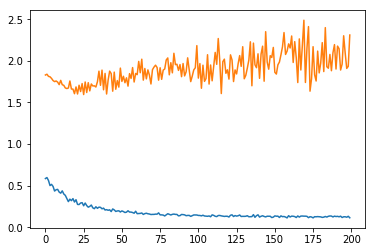

In [18]:
plt.plot(losses)

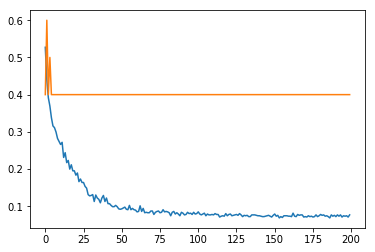

In [19]:
plt.plot(missclass)

In [20]:
model(x)

tensor([[ -0.3667,  -2.6526,  -1.4416],
        [ -0.4065,  -1.5173,  -2.1653],
        [ -3.3353,  -0.1027,  -2.7812],
        [ -0.6253,  -1.5444,  -1.3805],
        [ -2.0543,  -0.2054,  -2.8557],
        [ -9.8848,  -0.0005,  -7.7976],
        [ -4.3371,  -0.0132, -10.5439],
        [ -3.0642,  -0.1095,  -2.8644],
        [ -1.7500,  -0.1909, -14.1486],
        [ -7.5929,  -0.0067,  -5.0912]], grad_fn=<LogSoftmaxBackward>)

In [21]:
y

tensor([0, 0, 1, 1, 0, 1, 1, 0, 1, 2])

In [22]:
torch.max(preds, dim=1)

(tensor([-0.3667, -0.4065, -0.1027, -0.6253, -0.2054, -0.0005, -0.0132, -0.1095,
         -0.1909, -0.0067], grad_fn=<MaxBackward0>),
 tensor([0, 0, 1, 0, 1, 1, 1, 1, 1, 1]))

In [23]:
y == y_pred

tensor([1, 1, 1, 0, 0, 1, 1, 0, 1, 0], dtype=torch.uint8)